# Assignment 2: Machine Learning


You have 10 days to work on a machine learning algorithm.
I want you to pick one of the following use cases and make a prediction algorithm using either regression or classification algorithms.

Do the following:
1. Pick one use case (defined below).
    - We went with Use Case 2  
2. Explore and research which algorithm would work best for this use case (regression or classification)
    - Regression
3. Document your findings in a file (3-5 lines) on why you chose this algorithm.
    - We think Regression being the best, seing as we are not looking for a binary value of higher or lower, but rather "how high" and "how low", we are looking for a nuanced value, and therefore regression in the best fit.


TODO:

- Clean data properly

4. Train the algorithm using Python
5. Keep the solution as simple as possible. We are not looking for the best machine learning algorithm. We are interested in seeing that you know how to work with machine learning.
6. Publish the code on GitHub and send us the link


## Use Case 2 - Predict passenger data for Ruter
Use the same data set given to you in assignment 1. I want you to make a prediction algorithm which predicts the number of passengers on a specific date for a specific bus (pick any one). Input should be date and output will be number of passengers
You should also show the  prediction percentage score. Data file: Ruter_data.csv


In [593]:
# Imports

# numpy for math
import numpy as np
# pandas for dataframes
import pandas as pd
#importing datetime for format conversion
import datetime as dt

#improts for plott
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme(style="darkgrid")


# importing rest later

In [594]:
"""
First staring with making the .csv more manageable
"""

dataf = pd.read_csv("Ruter-data.csv", sep=";")

print(dataf["Linjenavn"].value_counts())
print(len(dataf.index))

100     465
110     362
390     247
31      220
360     189
       ... 
3772      1
3575      1
3833      1
3335      1
452       1
Name: Linjenavn, Length: 150, dtype: int64
6000


In [595]:
# We are only going to predict a single bus route, so dropping every other route, reducing from 6000 rows to just 110 rows
dataf = dataf[dataf['Linjenavn'] == "150"]

# Also dropping negative passager values, as these must be sensor misreadings
dataf = dataf[dataf['Passasjerer_Ombord'] >= 0]


print(dataf["Linjenavn"].value_counts())
print(len(dataf.index))

150    96
Name: Linjenavn, dtype: int64
96


In [596]:
# Testing to see if any columns could be dropped

print(dataf["Fylke"].value_counts())
print(dataf["Område"].value_counts())
print(dataf["Kommune"].value_counts())
print(dataf["Linjetype"].value_counts())
print(dataf["Linjefylke"].value_counts())
print(dataf["Kjøretøy_Kapasitet"].value_counts())


# Seems like linjetype, linjefylke and kjøretøy kapasitet can be dropped, as they contain the same value across the board
# Linjenavn can also be dropped, as of course, that is the same in every value, we just need to remember that it was for bus 150 hahah

Viken    75
Oslo     21
Name: Fylke, dtype: int64
Vest        80
Indre By    16
Name: Område, dtype: int64
Bærum            75
Sentrum           7
St.Hanshaugen     6
Ullern            5
Gamle Oslo        3
Name: Kommune, dtype: int64
Lokal    96
Name: Linjetype, dtype: int64
Viken    96
Name: Linjefylke, dtype: int64
112    96
Name: Kjøretøy_Kapasitet, dtype: int64


In [597]:
dataf.drop({'Linjetype', 'Linjefylke', 'Kjøretøy_Kapasitet', 'Linjenavn'}, axis=1, inplace=True)

dataf.head(1)

,TurId,Dato,Fylke,Område,Kommune,Holdeplass_Fra,Holdeplass_Til,Linjeretning,Tidspunkt_Faktisk_Ankomst_Holdeplass_Fra,Tidspunkt_Faktisk_Avgang_Holdeplass_Fra,Tidspunkt_Planlagt_Ankomst_Holdeplass_Fra,Tidspunkt_Planlagt_Avgang_Holdeplass_Fra,Passasjerer_Ombord
0,15006-2020-08-10T10:24:00+02:00,10/08/2020,Viken,Vest,Bærum,Nordliveien,Tjernsmyr,0,10:53:53,10:53:59,10:53:00,10:53:00,5


In [598]:
# Converting first to pandas time format, you can see the change in the Dato column, goes from "/" format to "-" format

dataf['Dato'] = pd.to_datetime(dataf['Dato'], errors='coerce')

dataf.head(1)

,TurId,Dato,Fylke,Område,Kommune,Holdeplass_Fra,Holdeplass_Til,Linjeretning,Tidspunkt_Faktisk_Ankomst_Holdeplass_Fra,Tidspunkt_Faktisk_Avgang_Holdeplass_Fra,Tidspunkt_Planlagt_Ankomst_Holdeplass_Fra,Tidspunkt_Planlagt_Avgang_Holdeplass_Fra,Passasjerer_Ombord
0,15006-2020-08-10T10:24:00+02:00,2020-10-08,Viken,Vest,Bærum,Nordliveien,Tjernsmyr,0,10:53:53,10:53:59,10:53:00,10:53:00,5


In [599]:
# Turning the pandas datetime format to a number value, determining distance from the date "01.01.01"

dataf['Dato'] = dataf['Dato'].map(dt.datetime.toordinal)

dataf.head(1)

,TurId,Dato,Fylke,Område,Kommune,Holdeplass_Fra,Holdeplass_Til,Linjeretning,Tidspunkt_Faktisk_Ankomst_Holdeplass_Fra,Tidspunkt_Faktisk_Avgang_Holdeplass_Fra,Tidspunkt_Planlagt_Ankomst_Holdeplass_Fra,Tidspunkt_Planlagt_Avgang_Holdeplass_Fra,Passasjerer_Ombord
0,15006-2020-08-10T10:24:00+02:00,737706,Viken,Vest,Bærum,Nordliveien,Tjernsmyr,0,10:53:53,10:53:59,10:53:00,10:53:00,5


In [600]:
# Setting data to a more sensible value, having day 1 being
# TODO: Might also have to group on date

# Figuring out the distance between dates based on max and min date 
print(max(dataf['Dato']) - min(dataf['Dato']))

# Storing this for later in case we want to correct the data back again
dateReduction = min(dataf['Dato']) - 1 

# Like this, first date should have a value of 1
dataf['Dato'] = dataf['Dato'] - dateReduction 

# Checking that we do not in fact have a 0 value
print(min(dataf['Dato'])) 

335
1


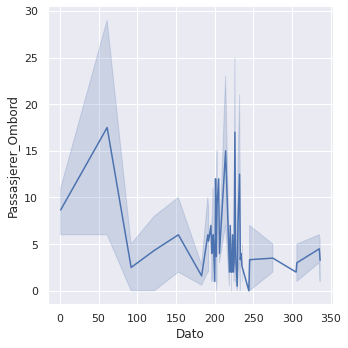

In [601]:
# Task is to predict passengers per day, so doing a quick relplot thus far

sns.relplot(x="Dato", y="Passasjerer_Ombord", kind="line", data=dataf)

# Guessing that the lack of precission is due to lack of grouping

In [602]:
# We see that a lot of days have multiple counts, and we need to group them, 110 rows are spread over 43 unique dates
print(len(dataf["Dato"].value_counts()))

41


In [606]:
"""
Sources that helped with this grouping and such:
https://www.geeksforgeeks.org/pandas-groupby/?ref=lbp
https://towardsdatascience.com/all-pandas-groupby-you-should-know-for-grouping-data-and-performing-operations-2a8ec1327b5

Espescially this one:
https://www.askpython.com/python-modules/pandas/conditionally-grouping-values

https://stackoverflow.com/questions/26323926/pandas-groupby-agg-how-to-return-results-without-the-multi-index
"""
dataf = dataf.groupby('Dato', axis=0, as_index=False).mean()

#engineering feature for weekday
dataf['Ukedag'] = dataf['Dato'] % 7

# dataf = dataf['Passasjerer_Ombord'].agg(np.mean)

dataf

"""
btw, either i did something massively wrong, or like this dataset is quite lacking, it doesn't even have daily entries on this bus, that goes like 4 times per hour every day, what is that all about?
"""

,Dato,Linjeretning,Passasjerer_Ombord,Ukedag
0,1,0.000000,8.666667,1
1,61,0.000000,17.500000,5
2,92,1.000000,2.500000,1
3,122,0.000000,4.333333,3
4,153,0.500000,6.000000,6
5,183,0.600000,1.600000,1
6,191,0.000000,6.000000,2
7,192,0.666667,5.333333,3
8,195,1.000000,7.000000,6
9,196,0.500000,4.000000,0


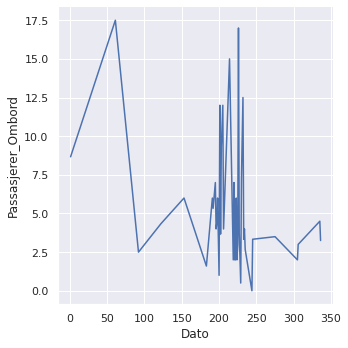

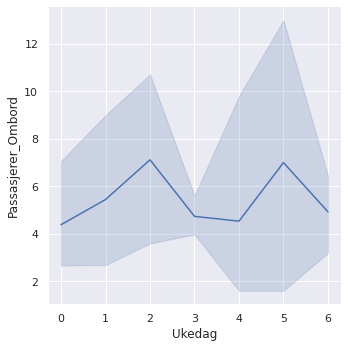

In [607]:
sns.relplot(x="Dato", y="Passasjerer_Ombord", kind="line", data=dataf)
sns.relplot(x="Ukedag", y="Passasjerer_Ombord", kind="line", data=dataf)


# even thought the other columns got a bit scuffed, then we see that the plot itself becomes much cleaner
# Grouping on weekday might give us better values for regression algorithm